<a href="https://colab.research.google.com/github/barefoothiker/EEG_Portal2/blob/master/SID4_SYDNEY_NMA_data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install external software packages
!pip install neurodsp

     |████████████████████████████████| 88 kB 3.3 MB/s 


In [2]:
#@title import analysis packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp import spectral

In [3]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data retrieval (LFP)

import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
#@title Data retrieval (behavior)
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [6]:
#@title Data loading

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
# dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
# dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = dat_LFP[11]
print(dat.keys())
dat_k = alldat[11]
print(dat_k.keys())
# dat = dat_WAV[11]
# print(dat.keys())
# dat = dat_ST[11]
# print(dat.keys())

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp'])
dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [7]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [8]:
alldat[0]['contrast_left'].shape # same shape (n_trials) as lfp

(214,)

In [9]:
target_area = 'VISp'

loc = dat_LFP[0]['brain_area_lfp'].index(target_area)

In [10]:
dat_LFP[0]['lfp'].shape # 7 electrode contacts (each with a different region), 214 trials, 250 samples per electrode (2.5 second trial @ 100Hz) ?

samples = dat_LFP[0]['lfp'].shape[2]
sfreq = samples/2.5 # 100 Hz sampling rate (nyquist @ 50 Hz)
shanks = dat_LFP[0]['lfp'].shape[0]
trials = dat_LFP[0]['lfp'].shape[1]

trials_pass = dat_LFP[0]['lfp_passive'].shape[1]

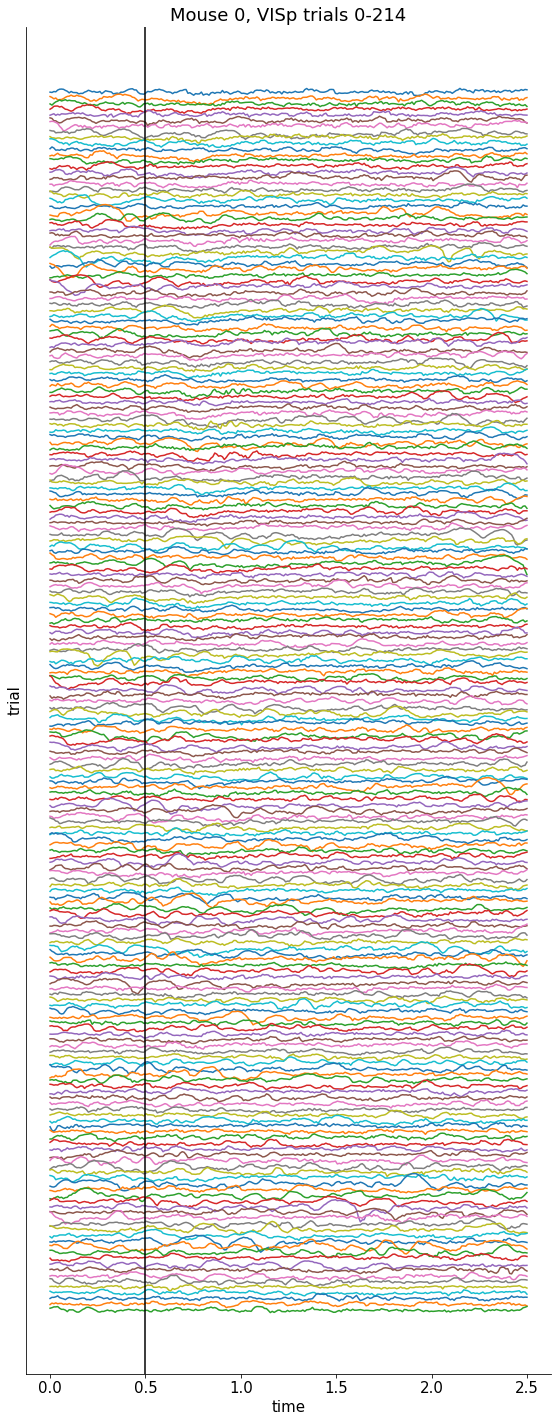

In [11]:
#@title Plot some raw data
x = np.linspace(0,2.5,samples)
dat = dat_LFP[0]['lfp'] # data from mouse 0 
dat_pas = dat_LFP[0]['lfp_passive'] # passive data from mouse 0
offset = 0

plt.figure(figsize=[8,20])

for i in range(1,trials):
  plt.plot(x,dat[loc][i]-offset) # plot single trial from VISp (loc 6)
  offset += 50
plt.axvline(0.5, color='k')
plt.xlabel('time')
plt.ylabel('trial')
plt.yticks([])
plt.title('Mouse 0, VISp trials 0-214')
plt.tight_layout()

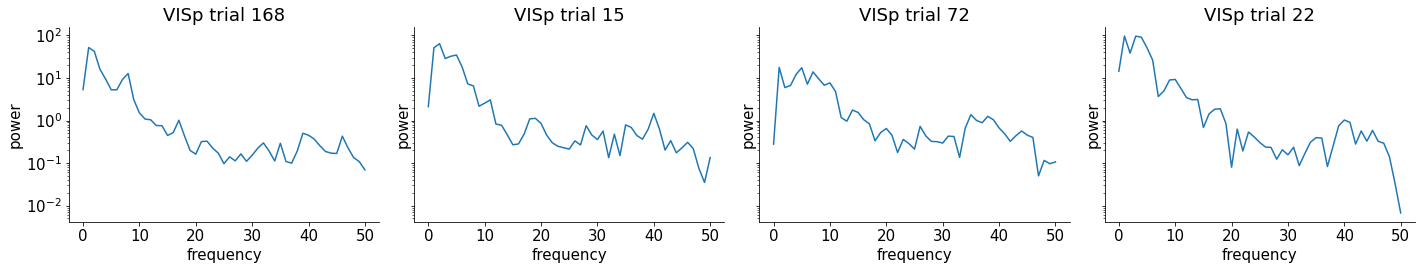

In [12]:
#@title Plot some power spectra (Welch)

fig, ax = plt.subplots(1,4, sharey=True)

np.random.seed(2)

for n, j in enumerate(np.random.randint(0,214,4)):
  freqs, spectrum = spectral.compute_spectrum_welch(dat[loc][j], fs=sfreq, avg_type='median',
                                                    window='hann', nperseg=sfreq, noverlap=sfreq/2)
  ax[n].plot(freqs, spectrum)
  ax[n].set_yscale('log')
  ax[n].set_title('VISp trial '+str(j))
  ax[n].set_xlabel('frequency')
  ax[n].set_ylabel('power') 

Seems like there's some decent gamma-band activity (30-50 Hz)? Let's try calculating spectra another way.



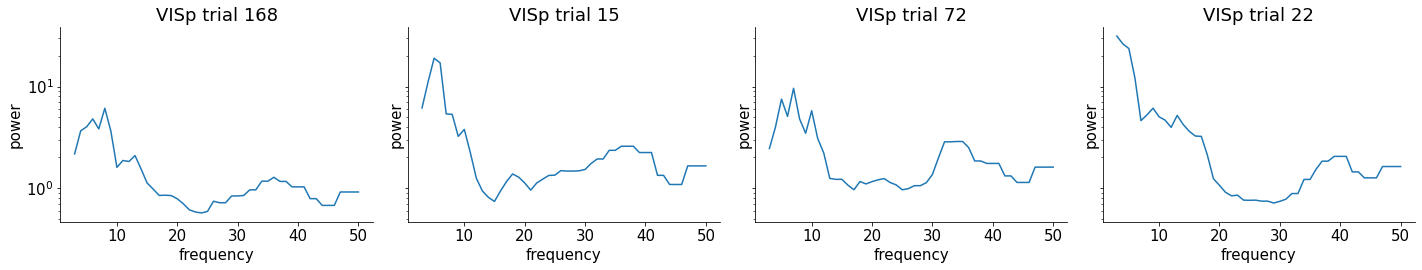

In [13]:
#@title Plot some power spectra (wavelet)

fig, ax = plt.subplots(1,4, sharey=True)

np.random.seed(2)

for n, j in enumerate(np.random.randint(0,214,4)):
  freqs, spectrum = spectral.compute_spectrum_wavelet(dat[loc][j], fs=sfreq,
                                                      freqs=[3,50], avg_type='median')
  ax[n].plot(freqs, spectrum)
  ax[n].set_yscale('log')
  ax[n].set_title('VISp trial '+str(j))
  ax[n].set_xlabel('frequency')
  ax[n].set_ylabel('power') 

Looks great. That 30-40Hz band looks fantastic, another potential candidate in ~10Hz.

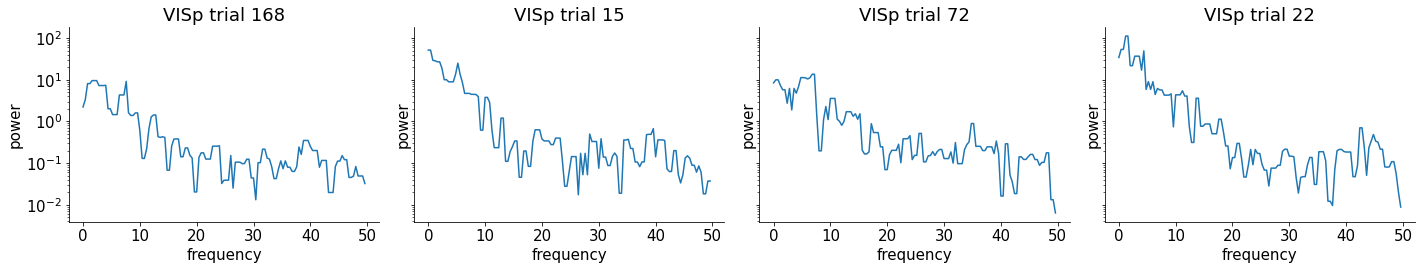

In [14]:
#@title Plot some power spectra (median filter smoothing)

fig, ax = plt.subplots(1,4, sharey=True)

np.random.seed(2)

for n, j in enumerate(np.random.randint(0,214,4)):
  freqs, spectrum = spectral.compute_spectrum_medfilt(dat[loc][j], fs=sfreq,
                                                      filt_len=1.0)
  ax[n].plot(freqs, spectrum)
  ax[n].set_yscale('log')
  ax[n].set_title('VISp trial '+str(j))
  ax[n].set_xlabel('frequency')
  ax[n].set_ylabel('power') 


Calculate average power spectrum over 214 trials using Welch method.

Text(0.5, 1.0, 'Mouse 0 average PSD over 214 trials')

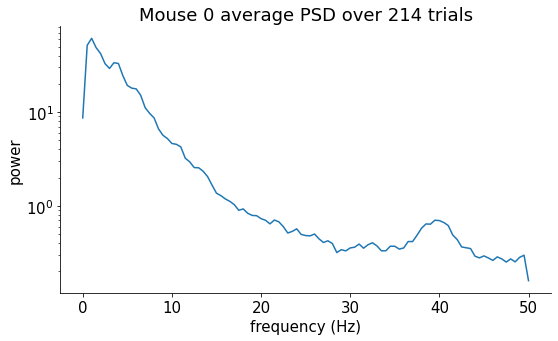

In [16]:
spectra = np.zeros([trials, int(sfreq)+1]) # empty array size n_trials, n_freqs

for trial in range(0,trials):
  freqs, spectrum = spectral.compute_spectrum_welch(dat[loc][trial], fs=sfreq, avg_type='median',
                                                    window='hann', nperseg=sfreq*2, noverlap=sfreq/8)
  spectra[trial,:] = spectrum

avg_spectrum = np.mean(spectra, axis=0)

plt.figure(figsize=[8,5])
plt.plot(freqs, avg_spectrum)
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('power')
plt.title('Mouse 0 average PSD over 214 trials')

Looks like there's consistent activity at 40 Hz for this mouse in the VISp area. Let's compare power in this band (35-45 Hz) to passive trials

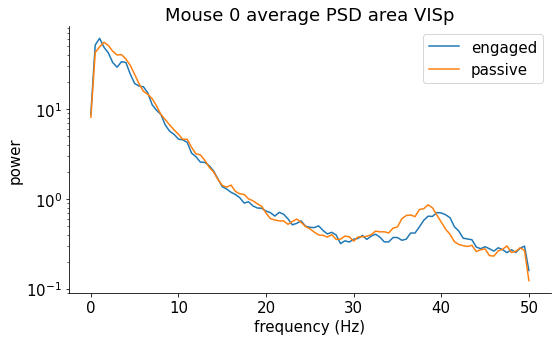

In [18]:
#@title Passive vs. Active trials PSD compariosn

# passive trials
spectra = np.zeros([trials_pass, int(sfreq)+1]) # empty array size n_trials, n_freqs

for trial in range(0,trials_pass):
  freqs, spectrum = spectral.compute_spectrum_welch(dat_pas[loc][trial], fs=sfreq, avg_type='median',
                                                    window='hann', nperseg=sfreq*2, noverlap=sfreq/2)
  spectra[trial,:] = spectrum

avg_spectrum_pass = np.mean(spectra, axis=0)

# active trails
spectra = np.zeros([trials, int(sfreq)+1]) # empty array size n_trials, n_freqs

for trial in range(0,trials):
  freqs, spectrum = spectral.compute_spectrum_welch(dat[loc][trial], fs=sfreq, avg_type='median',
                                                    window='hann', nperseg=sfreq*2, noverlap=sfreq/2)
  spectra[trial,:] = spectrum

avg_spectrum = np.mean(spectra, axis=0)

plt.figure(figsize=[8,5])
plt.plot(freqs, avg_spectrum, label='engaged')
plt.plot(freqs, avg_spectrum_pass, label='passive')
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('power')
plt.title('Mouse 0 average PSD area VISp')
plt.legend()

This is not super promising about 40 Hz being the magic band. However, we could look at specific center-frequency changes (i.e., a "speeding up" of 40Hz activity during engaged trials compared to passive trials). 

We'd need to use spectral parameterization (Donoghue et al, 2020). 

Also it's important to keep in mind that this is ONE mouse from ONE electrode.

Next steps: Look at spectra binned by contrast condition.

In [19]:
# get array of contrast difference
contrast_diffs = alldat[0]['contrast_left']-alldat[0]['contrast_right']

In [20]:
np.unique(contrast_diffs, return_counts=True)

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 array([21, 33, 28, 13, 58, 11, 24,  8, 18]))

In [21]:
# plot average psds of each contrast condition
from collections import defaultdict

sorted_spec_by_contrast = defaultdict(list)

for trial in range(0,trials):
  spectrum_trial = spectra[trial]
  contrast_diff_trial = contrast_diffs[trial]
  for i in contrast_diffs:
    if contrast_diff_trial == i:
      sorted_spec_by_contrast[str(i)].append(spectrum_trial)

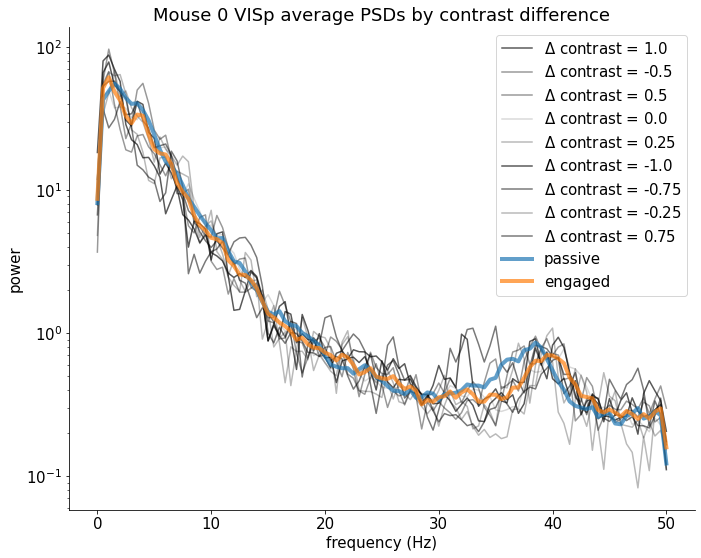

In [22]:
plt.figure(figsize=[10,8])

for contrast in sorted_spec_by_contrast:
  avg_spec = np.mean(sorted_spec_by_contrast[contrast], axis=0)
  plt.plot(freqs, avg_spec, color='k', alpha=np.abs(float(contrast)/2)+0.15, label='$\Delta$ contrast = '+str(contrast)) # line darkness = contrast difference

plt.plot(freqs, avg_spectrum_pass, lw=4, alpha=0.7, label='passive')
plt.plot(freqs, avg_spectrum, lw=4, alpha=0.7, label='engaged')

plt.title('Mouse 0 VISp average PSDs by contrast difference')
plt.ylabel('power')
plt.xlabel('frequency (Hz)')
plt.yscale('log')
plt.legend()

This doesn't look promising. There is very little variation between conditions. The only interesting thing to me is the difference between the passive and engaged trial conditions. 

This is still activity of just one mouse and only from visual cortex. Also the WHOLE TRIAL.

 Next steps: plot spectra of activity of only critical period (stim onset - 500ms)

Params to extract:

- amplitude envelope of band of interest
- aperiodic exponent
- offset
- band power
- gamma osc. center frequency
- gamma osc. power (above aperiodic)

In [23]:
!pip install pactools

     |████████████████████████████████| 82 kB 774 kB/s 
     |████████████████████████████████| 6.9 MB 6.8 MB/s 


In [24]:
methods = [
    'ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum'
]

ozkurt... 
canolty... 
tort... 
penny... 
vanwijk... 
duprelatour... 
colgin... 
sigl... 
bispectrum... 


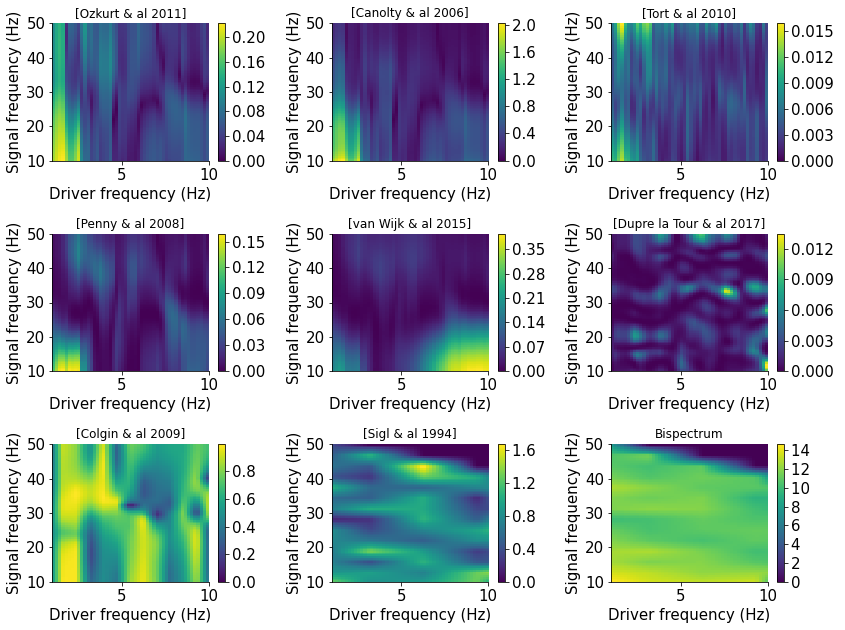

In [26]:
from pactools import Comodulogram, REFERENCES
# Define the subplots where the comodulogram will be plotted
n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))
fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
axs = axs.ravel()

# Compute the comodulograms and plot them
fs = 100
low_fq_range = np.linspace(1, 10, 50)
low_fq_width = 1.0  # Hz
signal = dat[loc][10]
for ax, method in zip(axs, methods):
    print('%s... ' % (method, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signal)
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])

plt.show()

In [29]:
n_surrogates = 200
n_jobs = 1
method = 'duprelatour'
estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                         low_fq_width=low_fq_width, method=method,
                         n_surrogates=n_surrogates, progress_bar=True,
                         n_jobs=n_jobs)
estimator.fit(signal)

[........................................] 100% | 113.24 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 113.26 sec | comodulogram: DAR(10, 1) 

/usr/local/lib/python3.7/dist-packages/pactools/comodulogram.py:507: UserWarning: No contour levels were found within the data range.
  origin='lower', extent=extent)


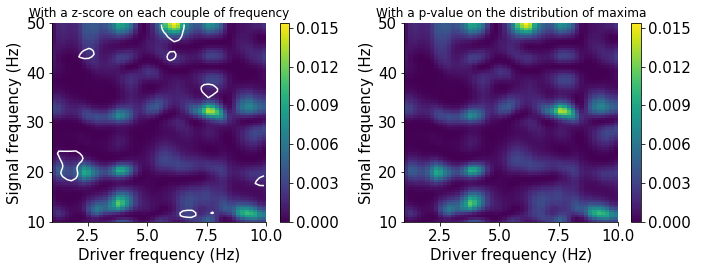

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

z_score = 4.
estimator.plot(contour_method='z_score', contour_level=z_score,
               titles=['With a z-score on each couple of frequency'],
               axs=[axs[0]])

p_value = 0.05
estimator.plot(contour_method='comod_max', contour_level=p_value,
               titles=['With a p-value on the distribution of maxima'],
               axs=[axs[1]])

plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


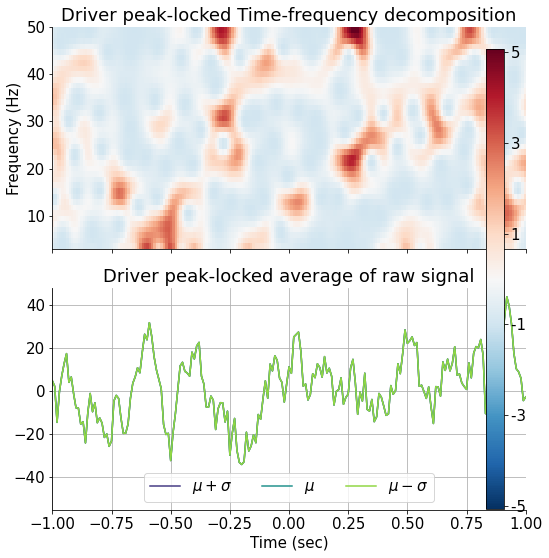

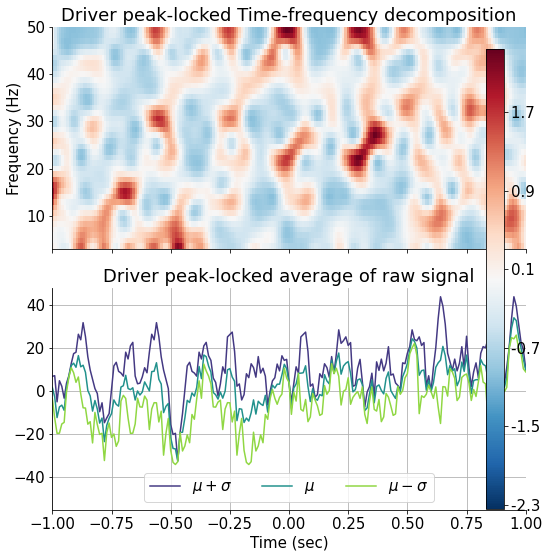

In [32]:
from pactools import PeakLocking
low_fq = 3.0  # Hz
low_fq_width = 2.0  # Hz
t_plot = 2.0  # sec

estimator = PeakLocking(fs=fs, low_fq=low_fq, low_fq_width=2.0, t_plot=t_plot)
estimator.fit(signal)
estimator.plot()

estimator = PeakLocking(fs=fs, low_fq=low_fq, low_fq_width=0.5, t_plot=t_plot)
estimator.fit(signal)
estimator.plot()

plt.show()